# IS319 - Deep Learning

## TP2 - Dogs vs. cats (PyTorch)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the PyTorch library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [3]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

PyTorch version: 2.0.1+cu117


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 1. Load and explore the dataset

In [6]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

Fichier ‘/tmp/cats_and_dogs_filtered.zip’ déjà présent ; pas de récupération.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.727.jpg', 'cat.60.jpg', 'cat.467.jpg', 'cat.683.jpg', 'cat.241.jpg', 'cat.626.jpg', 'cat.473.jpg', 'cat.699.jpg', 'cat.7.jpg', 'cat.982.jpg']
['dog.358.jpg', 'dog.852.jpg', 'dog.830.jpg', 'dog.510.jpg', 'dog.404.jpg', 'dog.691.jpg', 'dog.535.jpg', 'dog.651.jpg', 'dog.561.jpg', 'dog.956.jpg']


**(Question)** Display some images of cats and dogs from the train set and the validation set.

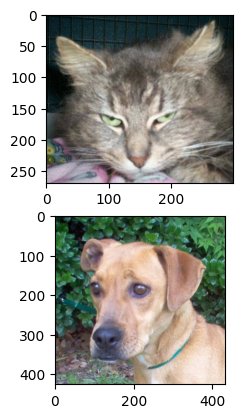

In [7]:
from PIL import Image

img = np.asarray(Image.open(os.path.join(train_cats_dir,train_cat_fnames[0])))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)

img = np.asarray(Image.open(os.path.join(train_dogs_dir,train_dog_fnames[0])))
plt.subplot(212)
plt.imshow(img)

## 2. Prepare the dataset

In [8]:
import os
import pandas as pd
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image

class CatsDogsDataset(Dataset):
    def __init__(self, dir):
        self.img_dir = dir

        cats_dir = os.path.join(dir, 'cats')
        dogs_dir = os.path.join(dir, 'dogs')

        self.X = os.listdir(cats_dir)
        lab_cats = np.zeros((len(self.X),1))
        # print(lab_cats)
        dogs = os.listdir(dogs_dir)
        lab_dogs = np.ones((len(dogs),1))
        self.X += dogs
        self.y = np.concatenate((lab_cats,lab_dogs))
        self.y = self.y.astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y[idx]==0:
            classe = 'cats'
        else:
            classe = 'dogs'
        dir = os.path.join(self.img_dir, classe)
        img_path = os.path.join(dir, self.X[idx])

        img = Image.open(img_path)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128, 128))
        ])
        img_tensor = transform(img)

        return img_tensor, self.y[idx]

In [9]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(CatsDogsDataset(train_dir), batch_size=16, shuffle=True)
test_dataloader = DataLoader(CatsDogsDataset(valid_dir), batch_size=16, shuffle=True)

## 5. Finetuning a pretrained model

In [10]:
from torchvision.models import vgg16
vgg_model = vgg16(pretrained = True).features

for param in vgg_model.parameters():
    param.requires_grad = False
print(vgg_model)

/home/ybelkhedra/IA_ENV/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ybelkhedra/IA_ENV/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [11]:
class VGG_finetune(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg_model
        self.fc1 = nn.Linear(512*4*4, 16)
        self.fc2 = nn.Linear(16,1)
        self.norm = nn.BatchNorm1d(1)

    def forward(self, X):
        X = self.vgg(X)
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.norm(X)
        X = F.sigmoid(X)
        return X

In [12]:
import torch.optim as optim
from torch.autograd import Variable

def fit(model,train, valid, epochs, criterion, optimizer):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        val_loss = 0.0
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(inputs)
            outputs = Variable((out>0.5).float(), requires_grad=True)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(outputs == labels)/labels.shape[0]
            running_loss += loss.item()

        model.eval()
        for j, (inputs, labels) in enumerate(valid):
            inputs = inputs.to(device)
            labels = labels.to(device)
            out = model(inputs)
            outputs = Variable((out>0.5).float(), requires_grad=True)
            loss = criterion(out, labels)
            val_acc += torch.sum(outputs == labels)/labels.shape[0]
            val_loss += loss.item()

        nb_data = len(train)
        nb_val = len(valid)
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / nb_data:.3f}, accuracy: {train_acc / nb_data:.3f} loss_val: {val_loss / nb_val:.3f}, accuracy_val: {val_acc / nb_val:.3f}')


In [13]:
model = VGG_finetune()
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
fit(model,train_dataloader, test_dataloader, 10, criterion, optimizer)

/home/ybelkhedra/IA_ENV/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[1,   125] loss: 0.397, accuracy: 0.900 loss_val: 0.341, accuracy_val: 0.952
[2,   125] loss: 0.146, accuracy: 0.954 loss_val: 0.125, accuracy_val: 0.952
[3,   125] loss: 0.069, accuracy: 0.978 loss_val: 0.130, accuracy_val: 0.950
[4,   125] loss: 0.030, accuracy: 0.995 loss_val: 0.134, accuracy_val: 0.947
[5,   125] loss: 0.014, accuracy: 1.000 loss_val: 0.131, accuracy_val: 0.949
[6,   125] loss: 0.007, accuracy: 1.000 loss_val: 0.136, accuracy_val: 0.949
[7,   125] loss: 0.004, accuracy: 1.000 loss_val: 0.141, accuracy_val: 0.948
[8,   125] loss: 0.002, accuracy: 1.000 loss_val: 0.146, accuracy_val: 0.950
[9,   125] loss: 0.002, accuracy: 1.000 loss_val: 0.151, accuracy_val: 0.950
[10,   125] loss: 0.001, accuracy: 1.000 loss_val: 0.156, accuracy_val: 0.950


In [14]:
#save weights of the model
torch.save(model.state_dict(), "model_weights.pth")

## Using GradCam to explain the results

In [28]:
## use gradcam to explain the prediction of the model
import cv2
from matplotlib import cm
from torch.autograd import Variable
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# def get_last_conv(model):
#     for name, module in model.named_modules():
#         if isinstance(module, torch.nn.Conv2d):
#             last_conv = module
#     return last_conv

def get_gradcam(model, img, device):
    # target_layer = get_last_conv(model)
    target_layers = [model.vgg[28], model.vgg[30]]
    grad_cam = GradCAM(model=model, target_layers=target_layers)
    input_tensor = img.unsqueeze(0)
    input_tensor = input_tensor.to(device)
    input_tensor = Variable(input_tensor, requires_grad=True)
    targets = None
    grayscale_cam = grad_cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    return grayscale_cam

def show_gradcam(model, img, device):
    grayscale_cam = get_gradcam(model, img, device)
    img = img.cpu().numpy().transpose(1, 2, 0)
    cam = show_cam_on_image(img, grayscale_cam)
    plt.imshow(cam)
    plt.show()

Label: dog
Prediction: cat
Confidence: 0.0010657187085598707


/home/ybelkhedra/IA_ENV/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


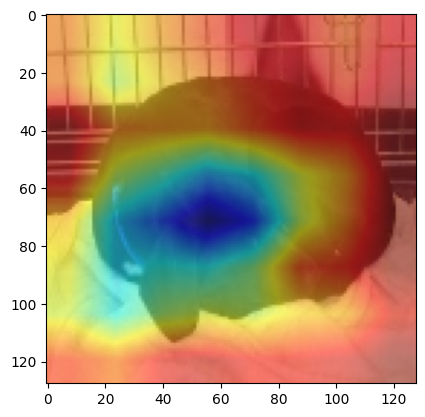

In [78]:
img_random_idx = np.random.randint(0, len(test_dataloader.dataset))
img, label = test_dataloader.dataset[img_random_idx]
prediction = model(img.unsqueeze(0).to(device))
prediction_ = (prediction>0.5).float()
dict = {0:'cat', 1:'dog'}

print(f'Label: {dict[label.item()]}')
print(f'Prediction: {dict[prediction_.item()]}')
print(f'Confidence: {prediction.item()}')

show_gradcam(model, img, device)